# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

In [951]:
# IMPORTS

import pandas
import pandas as pd
import numpy as np
import re
from typing import Union
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from typing import Callable

random_seed = 11

%matplotlib inline

In [952]:
# HELPERS

def get_frequency_counts(df: pd.DataFrame, column: str) -> dict:
    frequency_count = {}

    for ticket_id in df[column]:
        if ticket_id not in frequency_count:
            frequency_count[ticket_id] = 0

        frequency_count[ticket_id] += 1

    return frequency_count

# used for normalization
scaler = MinMaxScaler()


In [953]:
df = pd.read_csv('data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


<h2>Initial look at data and what will be processed</h2>

As we can see above, a lot of values are missing and data are dirty, we need to process them.

* pclass - ordinal value, all non null, no change needed
* name - it doesn't seem useful to predict which name will survive and which not, we'll drop this value. We can extract title, more below
* sex - nominal value, we'll apply one-hot encoding
* age - missing values, obviously a very useful metric, we'll predict missing values at the end
* sibsp - no change needed
* parch - no change needed
* ticket - we can extract useful information, more below
* fare - One value is missing. We'll need to fill it, more below
* cabin - a lot of values are missing, but there are still some values that are useful, more below
* embarked - nominal value, some values missing, more below
* home.dest - a lot of values are missing. The data is very dirty, often there's only 1 value, where we don't know what's home and what's dest, we'll
remove it

<h2>Processing data</h2>

Now we can finally start to process our data and fill the necessary missing values

<h3>Processing Name</h3>

It doesn't seem useful to predict which name will survive and which not, we'll drop this value. However, a name also contains a title of that person, which
can tell us useful things like marital status.

In [954]:
def find_title(name: str):
    titles = re.findall(r"[A-Z]\S+\.", name)
    if titles:
        return titles[0]
    return "Other"


df["name"].apply(find_title).value_counts()


Mr.          566
Miss.        210
Mrs.         155
Master.       45
Dr.            7
Rev.           4
Col.           4
Mlle.          2
Sir.           1
Capt.          1
Dona.          1
Ms.            1
Countess.      1
Mme.           1
Major.         1
Name: name, dtype: int64

As we can see, there are only 4 common titles, which tell us the marital status of the person. We'll definitely want those

Some titles mean the same thing, but are in different language, like Mlle. -> Miss., so we'll translate those.

Capt. seems also as an interesting title, as captains leave the boat as the latest, however we only have 1, and it's a passenger that paid a fare,
it shouldn't decrease their survival likelihood.

The full function is below

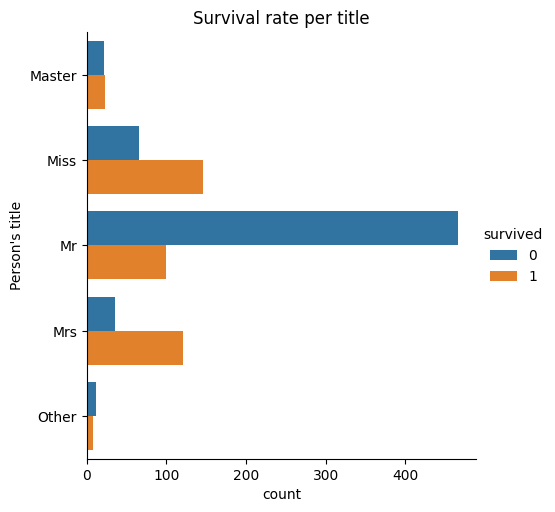

In [955]:
def get_title(name: str):
    translate_title = {
        "Mlle.": "Miss.",
        "Dona.": "Mrs.",
        "Mme.": "Mrs."
    }

    useful_titles = {"Mr.", "Miss.", "Mrs.", "Master.", "Mlle.", "Dona.", "Mme."}

    title = ""
    for useful_title in useful_titles:
        if useful_title in name:
            title = useful_title

    if title:
        if title in translate_title:
            title = translate_title[title]
        return title[:-1]
    return "Other"

df["title"] = df["name"].apply(get_title)
df.drop("name", axis=1)

graph = sns.catplot(y="title", hue="survived", data=df.sort_values(by='title'), kind="count");
graph.set(ylabel="Person's title", title="Survival rate per title");


<h3> Processing ticket </h3>

They’re usually unique numbers, we wouldn’t get much value out of it. However, there seems to be 2 types of tickets, one is that starts with a number and second one starts with a letter. There may be some value hidden there, we’ll split ticket into ones that start with a number and ones that start with a letter.



Yes    734
No     266
Name: ticket_starts_with_letter, dtype: int64


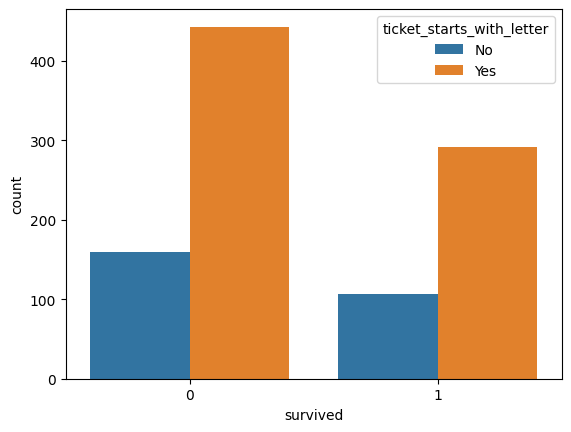

In [956]:
def categorize_ticket(ticket: Union[str, float]) -> str:
    if ticket == np.nan:  # protection in case future data have null
        return "No"
    ticket = ticket.strip()
    if ticket[0].isdigit():
        return "Yes"
    return "No"

df["ticket_starts_with_letter"] = df["ticket"].apply(categorize_ticket)
print(df["ticket_starts_with_letter"].value_counts())
sns.countplot(x='survived', hue ='ticket_starts_with_letter', data=df);


Based on the graph above, the letter of a ticket doesn't seem to be important, however, we can see that some people have the same ticket multiple times.
We can see if that value could have any impact

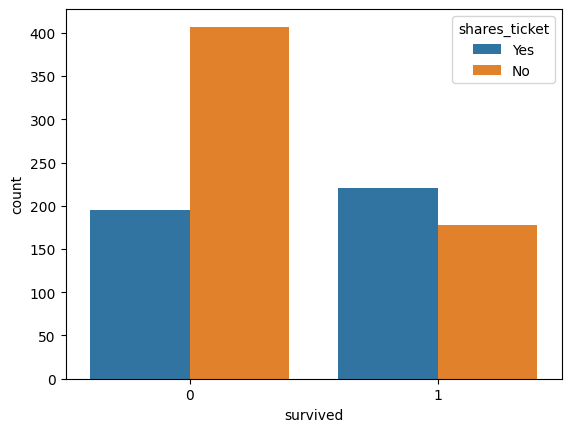

In [957]:
def find_if_duplicate_ticket(df: pandas.DataFrame):
    frequency_count = get_frequency_counts(df, "ticket")

    df["shares_ticket"] = df["ticket"].apply(lambda x: "Yes" if frequency_count[x] > 1 else "No")
    return df

df = find_if_duplicate_ticket(df)
df["shares_ticket"].value_counts()
df.drop("ticket", axis=1)

sns.countplot(x='survived', hue ='shares_ticket', data=df);

Based on the graph, it looks like people, who shared ticket were more likely to survive. We'll use this value from tickets, and not if they start with
a letter.

Fare
one value is missing. I’ve also seen instances when fare was 0. I won’t be changing this value and assuming that it was for free. There are no negative numbers, but if they were, I’m assuming that a passenger got paid.


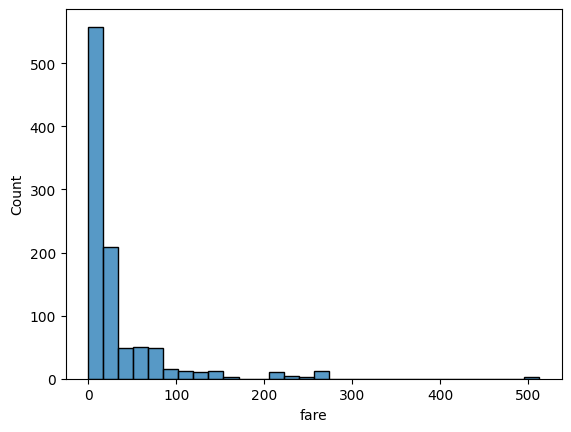

In [958]:
sns.histplot(df['fare'], bins=30, kde=False);

Fare prices seem to be skewed, that's why we'll use median to fill the missing values

In [959]:
df['fare'] = df['fare'].fillna(df['fare'].median())

Cabin

Most values are missing, that's why it's not reasonable to work with the text. Instead, if Cabin is not nan, we can take it as a person was in the cabin, otherwise they weren't.


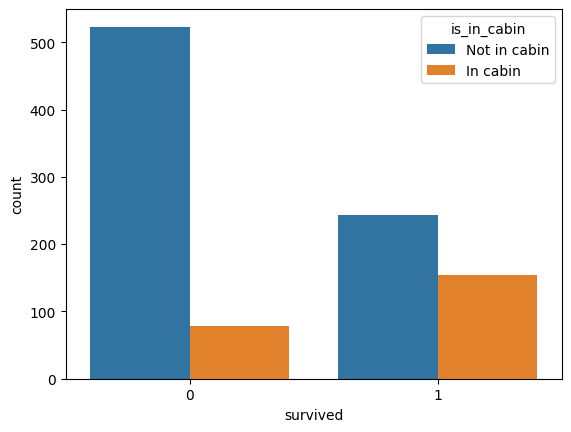

In [960]:
df["is_in_cabin"] = df["cabin"].apply(lambda x: "In cabin" if type(x) == str else "Not in cabin")
sns.countplot(x='survived', hue='is_in_cabin', data=df);


It seems like people in cabin are more likely to survive, we'll be including this value

Embarked

We have 2 missing values. As a person must've embarked from somewhere, since they're on the boat, we can conclude that these values are missing and
not intentionally nan.

We'll replace the data with the most used one.

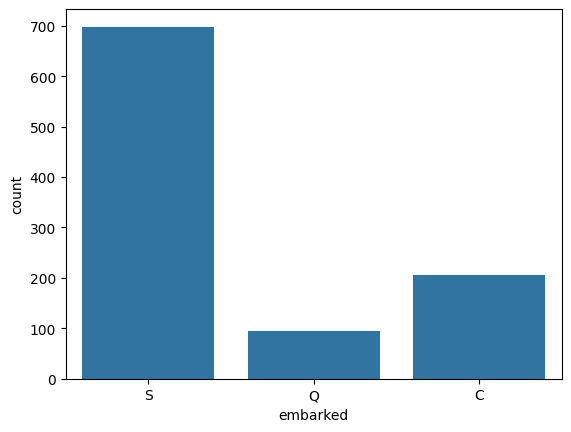

In [961]:
sns.countplot(x='embarked', data=df);

In [962]:
frequency_counts = get_frequency_counts(df, "embarked")
most_freq_embarked = max(frequency_counts, key=frequency_counts.get)
df["embarked"] = df["embarked"].apply(lambda x: most_freq_embarked if x == np.nan else x)

<h2>Splitting Data</h2>

Before applying our before-mentioned functions and processing the data, we need to split the data, because we don't want to risk over-fitting our model.

Since we're going to fill the missing data, we'll first split our data into training and testing set. We want to simulate the reality as much as possible while testing.

I'm not splitting my data into validation part, since that'll be done in the Cross validation.

In [963]:
# discard all previous changes, they were for explaining purposes
df = pd.read_csv('data.csv')

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    df.drop('survived', axis=1), df.survived, test_size=0.2, random_state=random_seed
)

<h2> Processing data - bringing it together </h2>

Now let's combine all the data processing above into a function.

We'll fill age after processing of the data, since we need this data in order to predict the age.

In [964]:

def process_data(df: pandas.DataFrame) -> pandas.DataFrame:
    df.set_index("ID", inplace=True)

    df["title"] = df["name"].apply(get_title)
    df = df.drop("name", axis=1)

    df = find_if_duplicate_ticket(df)
    df = df.drop("ticket", axis=1)

    df['fare'] = df['fare'].fillna(df['fare'].median())

    df["is_in_cabin"] = df["cabin"].apply(lambda x: "In cabin" if type(x) == str else "Not in cabin")
    df = df.drop("cabin", axis=1)

    frequency_counts = get_frequency_counts(df, "embarked")
    most_freq_embarked = max(frequency_counts, key=frequency_counts.get)
    df["embarked"] = df["embarked"].apply(lambda x: most_freq_embarked if x == np.nan else x)

    df = df.drop("home.dest", axis=1)

    # since all the data that are object are nominal now, we can apply one-hot encoding at the end to get the dummy values.
    df = pd.get_dummies(df)

    return df

Xtrain = process_data(Xtrain)

Xtrain
# df["title"].value_counts()


,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,shares_ticket_No,shares_ticket_Yes,is_in_cabin_In cabin,is_in_cabin_Not in cabin
ID,,,,,,,,,,,,,,,,,,,
832,3,18.0000,2,2,34.3750,0,1,0,0,1,0,0,1,0,0,0,1,0,1
797,2,18.0000,0,2,13.0000,1,0,0,0,1,0,1,0,0,0,1,0,0,1
49,3,NaN,0,0,7.2250,0,1,1,0,0,0,0,1,0,0,1,0,0,1
867,3,0.4167,0,1,8.5167,0,1,1,0,0,1,0,0,0,0,1,0,0,1
514,1,57.0000,1,1,164.8667,0,1,0,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3,18.5000,0,0,7.2292,0,1,1,0,0,0,0,1,0,0,1,0,0,1
91,1,64.0000,0,0,26.0000,0,1,0,0,1,0,0,1,0,0,1,0,0,1
80,3,NaN,0,0,7.8792,1,0,0,1,0,0,1,0,0,0,1,0,0,1


Predict age

I've tried to play around with DecisionTreeRegressor, however

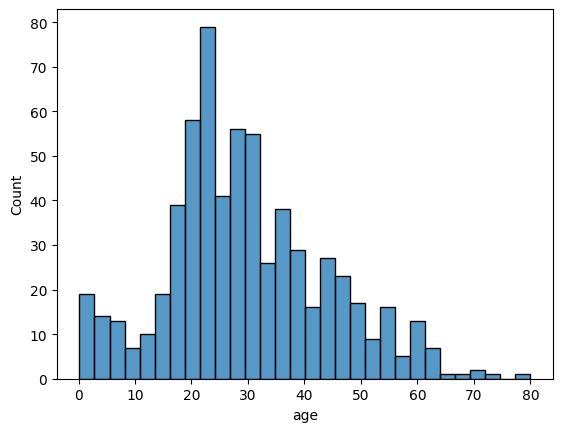

In [965]:
sns.histplot(Xtrain['age'], bins=30, kde=False);

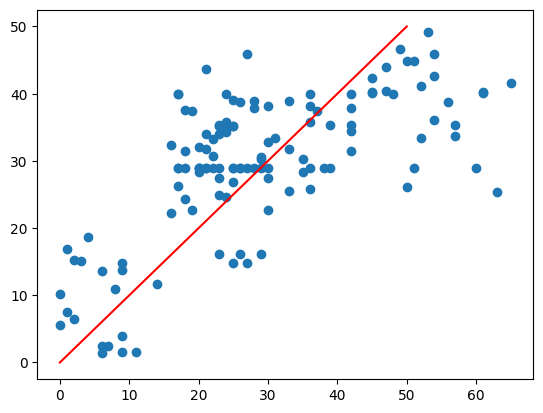

Squared error of predict age: 11.496817420671842


In [967]:
def get_trained_model(df: pd.DataFrame) -> (LinearRegression, list):

    # split the data into ones we'll train on and ones we'll predict
    # Using copy() to prevent warnings
    df_with_age = df[df['age'].notna()].copy()
    # since we'll want to work with ages as whole numbers, we'll get rid of the decimal places for training
    df_with_age["age"] = df_with_age["age"].astype(int)

    # split the data into X and Y
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
        df_with_age.drop('age', axis=1), df_with_age.age, test_size=0.2, random_state=random_seed
    )

    # normalize the data
    Xtrain_age = scaler.fit_transform(Xtrain)

    # find the most optimal depth
    decision_regressor = LinearRegression()
    # decision_regressor = DecisionTreeRegressor(max_depth=best_depth)
    decision_regressor.fit(Xtrain_age, Ytrain)

    predicted_ages = decision_regressor.predict(Xtest)
    plt.scatter(Ytest, predicted_ages)
    plt.plot([0,50], [0,50], 'r')
    plt.show()

    print('Squared error of predict age:', np.sqrt(mean_squared_error(np.array(Ytest), predicted_ages)))

    return decision_regressor, predicted_ages


def predict_age(df: pd.DataFrame, trained_model: DecisionTreeRegressor) -> pd.DataFrame:

    df_with_age = df[df['age'].notna()].copy()
    df_without_age = df[df['age'].isna()].copy()

    Xpredict = df_without_age.drop("age", axis=1)
    Xpredict = scaler.fit_transform(Xpredict)

    predicted_age = trained_model.predict(Xpredict)
    df_without_age["age"] = predicted_age

    df_to_attach = pd.concat([df_with_age, df_without_age], axis=0)
    df["age"] = df_to_attach["age"]

    # get rid of floats, round the age (since we did that for the training data)
    df["age"] = df["age"].apply(lambda x: int(round(x)))

    return df, df_without_age


age_predicting_model, predicted_ages = get_trained_model(Xtrain)
Xtrain, Xtrain_predicted_age = predict_age(Xtrain, age_predicting_model)


29.1250    35
35.2500    19
22.5625    14
27.7500    10
28.6250     4
           ..
39.1250     1
31.5625     1
34.2500     1
2.1250      1
20.1875     1
Name: age, Length: 67, dtype: int64

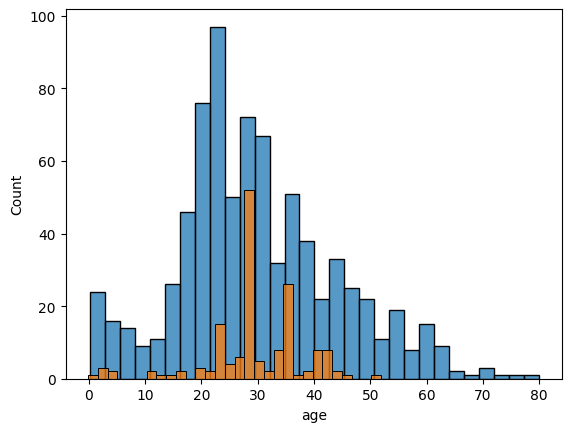

In [968]:
sns.histplot(df['age'], bins=30, kde=False);

sns.histplot(Xtrain_predicted_age['age'], bins=30, kde=False);

Xtrain_predicted_age['age'].value_counts()

In [ ]:
df.info()

<h2>Normalization</h2>

We want to normalize the data to avoid outliners from skewing our model data. For example the "fare" was heavily skewed towards cheaper prices, but there were some people
who paid a lot of money for the ticket.

In [969]:
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), index=Xtrain.index, columns=Xtrain.columns)

<h2>Decision tree</h2>

Now we're going to apply a decision tree algorithm to the processed and normalized training data to teach the model to predict who survives.

Decision trees are good when:
* We have a lot of columns, decision trees can be good at identifying what variables to discard and what are more important
* When we have a lot of categorical data (the increase of columns from dummy values don't pose a problem)
* The data set is huge - they require less RAM and computational complexity than KNN

Potential disadvantages:
* A tree can easily become biased, when disregarding variables
* Over-fitting - a tree can give too much weight to a certain column / data where it shouldn't be

Trees are very useful when we need to correctly interpret the mixed data and being biased towards a certain column / variable won't pose an issue.

<h3>Cross validation</h3>

We're going to use cross validation to pick the optimal hyperparameters for our decision tree.

In [970]:

def cross_validate(parameters, model_class: Callable):
    param_comb = ParameterGrid(parameters)

    val_metric = []
    for params in param_comb:
        clf = model_class(**params)
        # cross validation
        fold_acc = cross_val_score(clf, Xtrain, Ytrain, cv=5)
        val_metric.append(np.mean(fold_acc))

    best_params = param_comb[np.argmax(val_metric)]
    best_score = max(val_metric)

    print(f"Cross validation completed for {str(model_class)}, best hyperparameters: {best_params}, best validation score: {best_score}")

    return best_params, best_score, val_metric

decision_tree_max_depth = 50

param_grid = {
    'max_depth': range(1, decision_tree_max_depth),
    'criterion': ['gini', 'entropy', 'log_loss']
}

best_tree_params, best_tree_score, all_metrics = cross_validate(param_grid, DecisionTreeClassifier)

Cross validation completed for <class 'sklearn.tree._classes.DecisionTreeClassifier'>, best hyperparameters: {'max_depth': 5, 'criterion': 'entropy'}, best validation score: 0.7949999999999999


Plotting the hyperparameters:

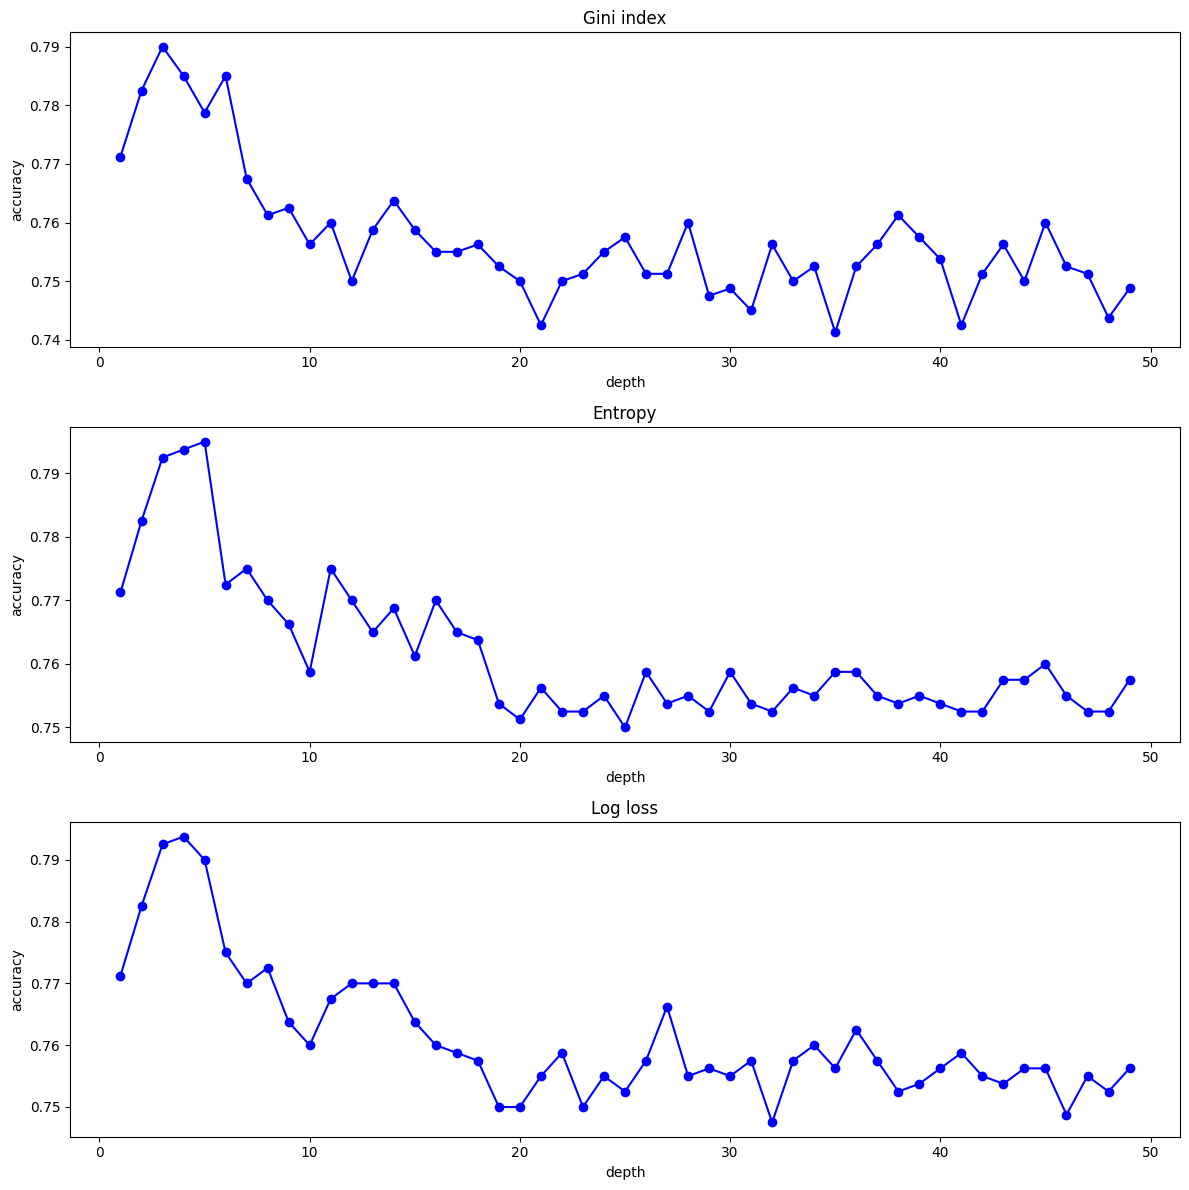

In [971]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(range(1, decision_tree_max_depth), all_metrics[:decision_tree_max_depth-1], 'ob-')
ax[0].set_title('Gini index')
ax[0].set_xlabel('depth')
ax[0].set_ylabel('accuracy')

ax[1].plot(range(1, decision_tree_max_depth), all_metrics[decision_tree_max_depth-1:decision_tree_max_depth*2-2], 'ob-')
ax[1].set_title('Entropy')
ax[1].set_xlabel('depth')
ax[1].set_ylabel('accuracy')

ax[2].plot(range(1, decision_tree_max_depth), all_metrics[decision_tree_max_depth*2-2:], 'ob-')
ax[2].set_title('Log loss')
ax[2].set_xlabel('depth')
ax[2].set_ylabel('accuracy')

plt.tight_layout()

<h2>K-Nearest Neighbors </h2>

Now we're going to train on the same data with the K-Nearest Neighbors algorithm.

KNN is good when:
* Compared to decision trees, there's no training needed, we're only waiting for the prediction time
* Doesn't make assumptions, less prone to over-fitting and bias

Potential disadvantages:
* Curse of dimensionality - the more columns we have, the further away our data are from each other, our performance is decreasing
* Large datasets would require a lot more computational power to predict than trees

KNN is useful when we don't have many columns and all have similar importance.

In [972]:
knn_max_neighbors = 50

param_grid = {
    'n_neighbors': range(1, knn_max_neighbors),
    'weights': ['uniform', 'distance'],
    "p": [1, 2]
}

best_knn_params, best_knn_score, all_metrics = cross_validate(param_grid, KNeighborsClassifier)

Cross validation completed for <class 'sklearn.neighbors._classification.KNeighborsClassifier'>, best hyperparameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 7}, best validation score: 0.80375


<h3>Analysis of the effectivity of Decision tree model on the test data</h3>

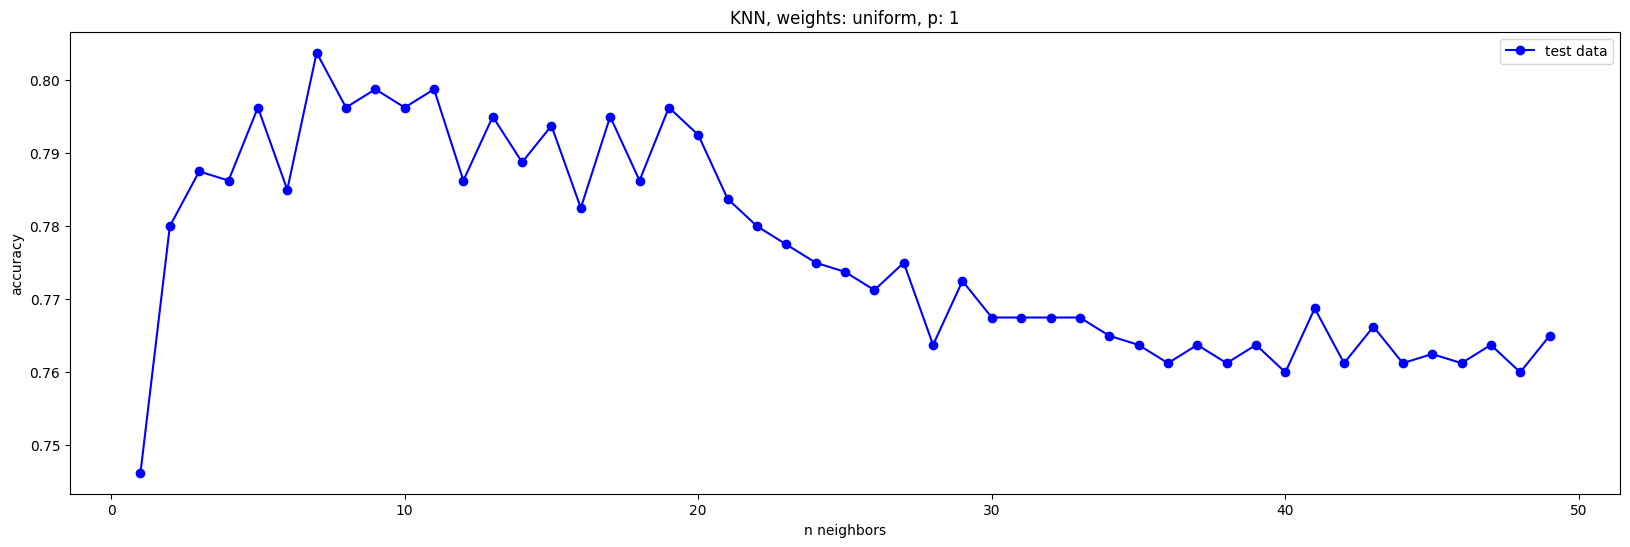

In [976]:
plt.figure(figsize=(20,6))
plt.plot(range(1, knn_max_neighbors), all_metrics[0::4], 'ob-')
plt.title("KNN, weights: uniform, p: 1")
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.legend(['test data']);


<h2>Analysis of the model's performance</h2>

We're going to analyse how well our model performs on a new data.

We'll use the test set, that we split from all the data in the beginning.

At first, we'll apply all the data transform, normalisation, age prediction, as we did for the train data.

In [ ]:
# apply data processing
Xtest = process_data(Xtest)
# fill ages
Xtest, _ = predict_age(Xtest, age_predicting_model)
# apply normalization
Xtest = pd.DataFrame(scaler.fit_transform(Xtest), index=Xtest.index, columns=Xtest.columns)


In [ ]:
best_decision_tree_model = DecisionTreeClassifier(**best_tree_params)
best_decision_tree_model.fit(Xtrain, Ytrain)

def plot_roc(model):
    Yprobability = model.predict_proba(Xtest)
    p1_hat = Yprobability[:,1]

    fpr, tpr, thresholds = roc_curve(Ytest, p1_hat)

    AUC = roc_auc_score(Ytest, p1_hat)

    plt.figure()
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC curve (AUC = {AUC:.3f})")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC křivka")
    plt.legend(loc="lower right")
    plt.show()

plot_roc(best_decision_tree_model)


In [ ]:
Ypredicted = best_decision_tree_model.predict(Xtest)

print(f'Accuracy score (test): {accuracy_score(Ytest, Ypredicted):.4f}')
print(f'F1 score (test): {f1_score(Ytest, Ypredicted):.4f}')

KNN neighbors

In [ ]:
best_knn_model = KNeighborsClassifier(**best_knn_params)
best_knn_model.fit(Xtrain, Ytrain)

Ypredicted = best_knn_model.predict(Xtest)

print(f'Accuracy score (test): {accuracy_score(Ytest, Ypredicted):.4f}')
print(f'F1 score (test): {f1_score(Ytest, Ypredicted):.4f}')

In [ ]:
plot_roc(best_knn_model)

As we can see, the KNN algorithm beat the DecisionTreeClassifier in all metrics, for:
* Cross validation score (for best hyperparameters) - 0.796 (tree) vs 0.809 (knn)
* Accuracy score of test data - 0.76 (tree) vs 0.79 (knn)
* F1 score of test data - 0.7209 (tree) vs 0.7273 (knn)
* AUC of test data - 0.798 (tree) vs 0.837 (knn)

Analysing the training of Decision tree

In [ ]:

feature_importances = best_decision_tree_model.feature_importances_

# Display feature importances
for feature, importance in zip(Xtrain.columns, feature_importances):
    print(f'{feature}: {importance}')